In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import time
import matplotlib.pyplot as plt
import hdf5storage
import scipy.io as scio
import h5py
%matplotlib inline

from keras.models import Sequential, model_from_json, Model, load_model
from keras.optimizers import SGD
from keras.layers import Input, Reshape, concatenate, Activation, Flatten, merge
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout
from keras import backend as K
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
#设置当前目录
root = '/home/smiletranquilly/FYP/Multi-Scale_Deep_Network' 
os.chdir(root)

coarse_dir='./coarse_data/building_coarse_model.h5'
coarse_weights='./coarse_data/building_coarse_weights.h5'
fine_dir='./fine_data/building_fine_model.h5'
fine_weights='./fine_data/building_fine_weights.h5'

log_corsepath = './tmp/building_corse_log'
log_finepath = './tmp/building_fine_log'

dataFile='/home/download/city.mat'

# 新建文件夹
isExists=os.path.exists('./coarse_data')    
if not isExists:
    # 如果不存在则创建目录
    os.makedirs('./coarse_data')
    
isExists=os.path.exists('./fine_data')
if not isExists:
    os.makedirs('./fine_data')
    
isExists=os.path.exists('./tmp')
if not isExists:
    os.makedirs('./tmp')
        

In [3]:
def scale_invarient_error(y_true,y_pred):
    log_1=K.log(K.clip(y_pred,K.epsilon(),np.inf)+1.)
    log_2=K.log(K.clip(y_true,K.epsilon(),np.inf)+1.)
    return K.mean(K.square(log_1-log_2),axis=-1)-Lambda*K.square(K.mean(log_1-log_2,axis=-1))

def pred_single_image_depth_using_fine(path):
    model=load_model(fine_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    img_array=cv2.imread(path)
    img_array=np.expand_dims(img_array,axis=0)
    img_array=np.array([cv2.resize(img_array[i],(480,640)) for i in range(1)])
    img_array=np.array([cv2.pyrDown(img_array[i]) for i in range(1)])
    img_array=rescale(img_array)
    out=model.predict(img_array)
    return out

def pred_single_image_depth_using_coarse(path):
    model=load_model(coarse_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    img_array=cv2.imread(path)
    img_array=np.expand_dims(img_array,axis=0)
    img_array=np.array([cv2.resize(img_array[i],(480,640)) for i in range(1)])
    img_array=np.array([cv2.pyrDown(img_array[i]) for i in range(1)])
    img_array=rescale(img_array)
    out=model.predict(img_array)
    return out

def pred_single_image_depth_using_coarse_array(image_array):
    model=load_model(coarse_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    image_array=np.expand_dims(image_array,axis=0)
    image_array=np.array([cv2.resize(image_array[i],(480,640)) for i in range(1)])
    image_array=np.array([cv2.pyrDown(image_array[i]) for i in range(1)])
    image_array=rescale(image_array)
    out=model.predict(image_array)
    return out

def pred_single_image_depth_using_fine_array(image_array):
    model=load_model(fine_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    image_array=np.expand_dims(image_array,axis=0)
    image_array=np.array([cv2.resize(image_array[i],(480,640)) for i in range(1)])
    image_array=np.array([cv2.pyrDown(image_array[i]) for i in range(1)])
    image_array=rescale(image_array)
    out=model.predict(image_array)
    return out
def display_image(path):
    img_array=plt.imread(path)
    img_array=np.expand_dims(img_array,axis=0) 
    img_array=np.array([cv2.resize(img_array[i],(480,640)) for i in range(1)])
    img_array=rescale(img_array)
    plt.imshow(img_array[0])
    
def eval(eval_dir):
    #load_model
    model=load_model(eval_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    print(model.evaluate(X_test,y_test))  
    
def rescale(data):
    data=data.astype('float32')
    data /= 255
    
    return data

def convert(mat,start,end):
# input must be matlab mat!
    X=[]
    y=[]
    img = mat['images'] #image
    depths = mat['depths'] # raw depths
    for i in range(start, end): # include left not right!
                img1 = img[i,...].transpose((1, 2, 0))
                img2 = depths[i]     #np.transpose() 
                X.append(img1)
                y.append(img2)
    return np.array(X),np.array(y)

# net defination

In [4]:
def train_coarse():
    inputs=Input(shape=(int(img_row/2),int(img_cols/2),3))

    #coarse_1
    coarse_1=Convolution2D(96,(11,11),strides=(4,4),padding='same')(inputs)
    coarse_1=Activation('relu')(coarse_1)
    coarse_1=MaxPooling2D(pool_size=(2, 2))(coarse_1)

    #coarse_2
    coarse_2=Convolution2D(256,(5,5),padding='same')(coarse_1)
    coarse_2=Activation('relu')(coarse_2)
    coarse_2=MaxPooling2D(pool_size=(2,2))(coarse_2)

    #coarse_3
    coarse_3=Convolution2D(384,(3,3),padding='same')(coarse_2)
    coarse_3=Activation('relu')(coarse_3)

    #coarse_4
    coarse_4=Convolution2D(384,(3,3),padding='same')(coarse_3)
    coarse_4=Activation('relu')(coarse_4)

    #coarse_5
    coarse_5=Convolution2D(256,(3,3),padding='same',)(coarse_4)
    coarse_5=Activation('relu')(coarse_5)
    coarse_5=MaxPooling2D(pool_size=(2,2))(coarse_5)

    #coarse_6
    coarse_6=Flatten(name='coarse_6')(coarse_5)
    coarse_6=Dense(4096)(coarse_6)
    coarse_6=Activation('relu')(coarse_6)
    coarse_6=Dropout(0.5)(coarse_6)

    # Coarse 7
    coarse_7=Dense((int(img_row/8))*(int(img_cols/8)))(coarse_6)
    coarse_7=Activation('linear')(coarse_7)
    coarse_7=Reshape((int(img_row/8),int(img_cols/8)))(coarse_7)
        
    model=Model(input=inputs,output=coarse_7)
    model.compile(loss=scale_invarient_error,optimizer=SGD(learning_rate,momentum),metrics=['accuracy'])
    
    #print model
    model.summary() 
    
    try:
        os.makedirs(log_corsepath)
    except:
        pass
    #将loss ，acc， val_loss ,val_acc记录tensorboard
    tensorboard = TensorBoard(log_dir=log_corsepath)#, histogram_freq=1,write_graph=True,write_images=1
                           
    model.fit(X_train,y_train,epochs=coarse_epochs,batch_size=batch_size,shuffle=True,validation_split=0.2,callbacks=[tensorboard])
                               
    #save_model
    model.save(coarse_dir)
 

def train_fine():
    #load_coarse_model:
    model=load_model(coarse_dir,custom_objects={'scale_invarient_error':scale_invarient_error})
    
    for layers in model.layers:
        layers.trainable=False
    
    #fine_model
    inputs=model.input
    
    #fine_1:
    fine_1=Convolution2D(63,(9,9),strides=(2,2),padding='same')(inputs)
    fine_1=Activation('relu')(fine_1)
    fine_1=MaxPooling2D(pool_size=(2,2))(fine_1)
    
    #fine_2:
    coarse_output=model.output
    coarse_output=Reshape((int(img_row/8),int(img_cols/8),1))(coarse_output)
    fine_2=concatenate([fine_1,coarse_output],axis=3)
    
    #fine_3:
    fine_3=Convolution2D(64,(5,5),padding='same')(fine_2)
    fine_3=Activation('relu')(fine_3)
    
    #fine_4:
    fine_4=Convolution2D(1,(5,5),padding='same')(fine_3)
    fine_4=Activation('linear')(fine_4)
    fine_4=Reshape((int(img_row/8),int(img_cols/8)))(fine_4)
    
    model=Model(input=inputs,output=fine_4)
    model.compile(loss=scale_invarient_error,optimizer=SGD(learning_rate,momentum),metrics=['accuracy'])
    
    model.summary()
    
    try:
        os.makedirs(log_finepath)
    except:
        pass
    #将loss ，acc， val_loss ,val_acc记录tensorboard
    tensorboard = TensorBoard(log_dir=log_finepath) #, histogram_freq=1,write_graph=True,write_images=1
    history = model.fit(X_train,y_train,batch_size=batch_size,epochs=fine_epoches,shuffle=True,validation_split=0.2,callbacks=[tensorboard])
    
    #save model
    model.save(fine_dir)


Flattening是把一个输入的大小为n \* c \* h \* w变成一个简单的向量，其大小为 n \* (c\*h\*w) \* 1 \* 1。

# test

In [18]:
mat = []
mat.append(h5py.File(dataFile[0]))
print mat[0].keys()
print mat[0].values()
img = mat[0]['images']
print img

[u'depths', u'images']
[<HDF5 dataset "depths": shape (192, 640, 480), type "<f8">, <HDF5 dataset "images": shape (192, 3, 640, 480), type "<f8">]
<HDF5 dataset "images": shape (192, 3, 640, 480), type "<f8">


# Feature engineering

In [5]:
mat = h5py.File(dataFile)
# number of the first dim
image_num = len(mat['images']) 
depth_num = len(mat['depths'])
try:
    image_num == depth_num
except IOError:
    print "number not match, input error!"

X_1,y_1=convert(mat,0,image_num/4)
X_2,y_2=convert(mat,image_num/4,image_num/2)
X_3,y_3=convert(mat,image_num/2,3*image_num/4)
X_4,y_4=convert(mat,3*image_num/4,image_num)
print(X_1.shape,y_1.shape)
print(X_2.shape,y_2.shape)
print(X_3.shape,y_3.shape)
print(X_4.shape,y_4.shape)

X_5=np.concatenate((X_1,X_2),axis=0)
# release memory
del X_1,X_2
y_5=np.concatenate((y_1,y_2),axis=0)
del y_1,y_2

X_6=np.concatenate((X_4,X_3),axis=0)
del X_4,X_3
y_6=np.concatenate((y_4,y_3),axis=0)    
del y_4,y_3

X_data = np.concatenate((X_5,X_6),axis=0)
del X_5,X_6
y_data = np.concatenate((y_5,y_6),axis=0)
del y_5,y_6
print(X_data.shape,y_data.shape)
# 归一化
X_data=rescale(X_data)
y_data=rescale(y_data)


((209, 640, 480, 3), (209, 640, 480))
((209, 640, 480, 3), (209, 640, 480))
((209, 640, 480, 3), (209, 640, 480))
((209, 640, 480, 3), (209, 640, 480))
((836, 640, 480, 3), (836, 640, 480))


In [6]:
train_end=int(0.8*image_num)
test_num= image_num - train_end
X_train=X_data[:train_end]
y_train=y_data[:train_end]

X_test=X_data[train_end:image_num]
y_test=y_data[train_end:image_num]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train=np.array([cv2.pyrDown(X_train[i]) for i in range(train_end)])
y_train=np.array([cv2.pyrDown(y_train[i]) for i in range(train_end)])
X_test=np.array([cv2.pyrDown(X_test[i]) for i in range(test_num)])
y_test=np.array([cv2.pyrDown(y_test[i]) for i in range(test_num)])

y_train=np.array([cv2.pyrDown(y_train[i]) for i in range(train_end)])
y_test=np.array([cv2.pyrDown(y_test[i]) for i in range(test_num)])
y_train=np.array([cv2.pyrDown(y_train[i]) for i in range(train_end)])
y_test=np.array([cv2.pyrDown(y_test[i]) for i in range(test_num)])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(668, 640, 480, 3)
(668, 640, 480)
(168, 640, 480, 3)
(168, 640, 480)
(668, 320, 240, 3)
(668, 80, 60)
(168, 320, 240, 3)
(168, 80, 60)


# Configurations

In [7]:
batch_size=32
coarse_epochs = 1000
fine_epoches = 1000
img_row=640
img_cols=480
learning_rate=0.1
momentum=0.9
Lambda=0.5

# train

In [8]:
%time
train_coarse()
train_fine()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 240, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 60, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 80, 60, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 30, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 30, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 40, 30, 256)       0         
_________________________________________________________________
max_pool

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("re..., inputs=Tensor("in...)`


Train on 534 samples, validate on 134 samples
Epoch 1/1000
534/534 [==============================] - 8s 15ms/step - loss: 0.0017 - acc: 0.0171 - val_loss: 0.0022 - val_acc: 0.0220
Epoch 2/1000
534/534 [==============================] - 5s 9ms/step - loss: 0.0017 - acc: 0.0186 - val_loss: 0.0022 - val_acc: 0.0210
Epoch 3/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0017 - acc: 0.0177 - val_loss: 0.0022 - val_acc: 0.0206
Epoch 4/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0017 - acc: 0.0175 - val_loss: 0.0022 - val_acc: 0.0204
Epoch 5/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0017 - acc: 0.0178 - val_loss: 0.0021 - val_acc: 0.0203
Epoch 6/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0017 - acc: 0.0169 - val_loss: 0.0021 - val_acc: 0.0195
Epoch 7/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0017 - acc: 0.0165 - val_loss: 0.0021 - val_acc: 0.0192
Epoch 8/10

Epoch 61/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0015 - acc: 0.0163 - val_loss: 0.0018 - val_acc: 0.0145
Epoch 62/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0015 - acc: 0.0163 - val_loss: 0.0018 - val_acc: 0.0144
Epoch 63/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0015 - acc: 0.0170 - val_loss: 0.0018 - val_acc: 0.0141
Epoch 64/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0015 - acc: 0.0162 - val_loss: 0.0018 - val_acc: 0.0140
Epoch 65/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0015 - acc: 0.0167 - val_loss: 0.0017 - val_acc: 0.0137
Epoch 66/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0015 - acc: 0.0168 - val_loss: 0.0017 - val_acc: 0.0135
Epoch 67/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0015 - acc: 0.0165 - val_loss: 0.0017 - val_acc: 0.0135
Epoch 68/1000
534/534 [=========================

534/534 [==============================] - 5s 10ms/step - loss: 0.0013 - acc: 0.0170 - val_loss: 0.0015 - val_acc: 0.0129
Epoch 122/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0013 - acc: 0.0170 - val_loss: 0.0015 - val_acc: 0.0131
Epoch 123/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0013 - acc: 0.0168 - val_loss: 0.0015 - val_acc: 0.0126
Epoch 124/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0013 - acc: 0.0157 - val_loss: 0.0015 - val_acc: 0.0125
Epoch 125/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0013 - acc: 0.0158 - val_loss: 0.0015 - val_acc: 0.0132
Epoch 126/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0013 - acc: 0.0159 - val_loss: 0.0015 - val_acc: 0.0130
Epoch 127/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0013 - acc: 0.0166 - val_loss: 0.0015 - val_acc: 0.0132
Epoch 128/1000
534/534 [==============================] 

Epoch 181/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0012 - acc: 0.0166 - val_loss: 0.0013 - val_acc: 0.0149
Epoch 182/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0012 - acc: 0.0165 - val_loss: 0.0013 - val_acc: 0.0149
Epoch 183/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0012 - acc: 0.0166 - val_loss: 0.0013 - val_acc: 0.0148
Epoch 184/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0012 - acc: 0.0166 - val_loss: 0.0013 - val_acc: 0.0151
Epoch 185/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0012 - acc: 0.0176 - val_loss: 0.0013 - val_acc: 0.0152
Epoch 186/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0012 - acc: 0.0175 - val_loss: 0.0013 - val_acc: 0.0157
Epoch 187/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0012 - acc: 0.0163 - val_loss: 0.0013 - val_acc: 0.0152
Epoch 188/1000
534/534 [=================

Epoch 241/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0011 - acc: 0.0164 - val_loss: 0.0011 - val_acc: 0.0165
Epoch 242/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0011 - acc: 0.0158 - val_loss: 0.0011 - val_acc: 0.0168
Epoch 243/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0011 - acc: 0.0173 - val_loss: 0.0011 - val_acc: 0.0171
Epoch 244/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0011 - acc: 0.0172 - val_loss: 0.0011 - val_acc: 0.0168
Epoch 245/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0011 - acc: 0.0158 - val_loss: 0.0011 - val_acc: 0.0170
Epoch 246/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0011 - acc: 0.0163 - val_loss: 0.0011 - val_acc: 0.0169
Epoch 247/1000
534/534 [==============================] - 5s 10ms/step - loss: 0.0011 - acc: 0.0172 - val_loss: 0.0011 - val_acc: 0.0178
Epoch 248/1000
534/534 [=================

534/534 [==============================] - 5s 10ms/step - loss: 0.0010 - acc: 0.0168 - val_loss: 9.7745e-04 - val_acc: 0.0174
Epoch 301/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.9958e-04 - acc: 0.0178 - val_loss: 9.8814e-04 - val_acc: 0.0175
Epoch 302/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.9799e-04 - acc: 0.0166 - val_loss: 9.8101e-04 - val_acc: 0.0175
Epoch 303/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.9895e-04 - acc: 0.0174 - val_loss: 9.7833e-04 - val_acc: 0.0174
Epoch 304/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.9431e-04 - acc: 0.0166 - val_loss: 9.7883e-04 - val_acc: 0.0179
Epoch 305/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.9514e-04 - acc: 0.0178 - val_loss: 9.7810e-04 - val_acc: 0.0177
Epoch 306/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.9341e-04 - acc: 0.0177 - val_loss: 9.7411e-04 - val_acc: 0.0173
Epoc

534/534 [==============================] - 5s 10ms/step - loss: 9.4270e-04 - acc: 0.0182 - val_loss: 8.9930e-04 - val_acc: 0.0179
Epoch 357/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.4143e-04 - acc: 0.0159 - val_loss: 9.0544e-04 - val_acc: 0.0182
Epoch 358/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.4026e-04 - acc: 0.0171 - val_loss: 9.0176e-04 - val_acc: 0.0182
Epoch 359/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.4193e-04 - acc: 0.0162 - val_loss: 8.9834e-04 - val_acc: 0.0189
Epoch 360/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.3827e-04 - acc: 0.0166 - val_loss: 8.9944e-04 - val_acc: 0.0186
Epoch 361/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.3873e-04 - acc: 0.0168 - val_loss: 8.9624e-04 - val_acc: 0.0186
Epoch 362/1000
534/534 [==============================] - 5s 10ms/step - loss: 9.3849e-04 - acc: 0.0171 - val_loss: 8.9959e-04 - val_acc: 0.0186


534/534 [==============================] - 5s 10ms/step - loss: 8.9759e-04 - acc: 0.0170 - val_loss: 8.3909e-04 - val_acc: 0.0184
Epoch 413/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.9712e-04 - acc: 0.0160 - val_loss: 8.3595e-04 - val_acc: 0.0189
Epoch 414/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.9684e-04 - acc: 0.0168 - val_loss: 8.4342e-04 - val_acc: 0.0177
Epoch 415/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.9814e-04 - acc: 0.0164 - val_loss: 8.4480e-04 - val_acc: 0.0175
Epoch 416/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.9406e-04 - acc: 0.0176 - val_loss: 8.3698e-04 - val_acc: 0.0170
Epoch 417/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.9590e-04 - acc: 0.0174 - val_loss: 8.3611e-04 - val_acc: 0.0169
Epoch 418/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.9498e-04 - acc: 0.0166 - val_loss: 8.3483e-04 - val_acc: 0.0177


534/534 [==============================] - 5s 10ms/step - loss: 8.6578e-04 - acc: 0.0170 - val_loss: 7.9603e-04 - val_acc: 0.0170
Epoch 469/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.6348e-04 - acc: 0.0172 - val_loss: 7.9434e-04 - val_acc: 0.0172
Epoch 470/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.6436e-04 - acc: 0.0168 - val_loss: 7.9510e-04 - val_acc: 0.0173
Epoch 471/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.6462e-04 - acc: 0.0175 - val_loss: 7.9070e-04 - val_acc: 0.0170
Epoch 472/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.6422e-04 - acc: 0.0165 - val_loss: 7.9848e-04 - val_acc: 0.0181
Epoch 473/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.6568e-04 - acc: 0.0175 - val_loss: 7.9151e-04 - val_acc: 0.0174
Epoch 474/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.6085e-04 - acc: 0.0162 - val_loss: 7.9535e-04 - val_acc: 0.0175


534/534 [==============================] - 5s 10ms/step - loss: 8.4001e-04 - acc: 0.0167 - val_loss: 7.6120e-04 - val_acc: 0.0172
Epoch 525/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.4086e-04 - acc: 0.0164 - val_loss: 7.5822e-04 - val_acc: 0.0177
Epoch 526/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.3914e-04 - acc: 0.0174 - val_loss: 7.5779e-04 - val_acc: 0.0176
Epoch 527/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.3671e-04 - acc: 0.0158 - val_loss: 7.5530e-04 - val_acc: 0.0175
Epoch 528/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.3864e-04 - acc: 0.0172 - val_loss: 7.5843e-04 - val_acc: 0.0176
Epoch 529/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.3719e-04 - acc: 0.0173 - val_loss: 7.5572e-04 - val_acc: 0.0175
Epoch 530/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.3725e-04 - acc: 0.0177 - val_loss: 7.5292e-04 - val_acc: 0.0174


534/534 [==============================] - 5s 10ms/step - loss: 8.1692e-04 - acc: 0.0175 - val_loss: 7.3176e-04 - val_acc: 0.0173
Epoch 581/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.1828e-04 - acc: 0.0166 - val_loss: 7.2621e-04 - val_acc: 0.0181
Epoch 582/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.1793e-04 - acc: 0.0166 - val_loss: 7.2834e-04 - val_acc: 0.0180
Epoch 583/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.1819e-04 - acc: 0.0167 - val_loss: 7.3572e-04 - val_acc: 0.0178
Epoch 584/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.1682e-04 - acc: 0.0160 - val_loss: 7.2092e-04 - val_acc: 0.0177
Epoch 585/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.1646e-04 - acc: 0.0168 - val_loss: 7.2776e-04 - val_acc: 0.0185
Epoch 586/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.1650e-04 - acc: 0.0172 - val_loss: 7.2681e-04 - val_acc: 0.0178


534/534 [==============================] - 5s 10ms/step - loss: 8.0088e-04 - acc: 0.0163 - val_loss: 7.0454e-04 - val_acc: 0.0194
Epoch 637/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.9981e-04 - acc: 0.0176 - val_loss: 6.9669e-04 - val_acc: 0.0188
Epoch 638/1000
534/534 [==============================] - 5s 10ms/step - loss: 8.0006e-04 - acc: 0.0173 - val_loss: 6.9973e-04 - val_acc: 0.0191
Epoch 639/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.9922e-04 - acc: 0.0181 - val_loss: 7.0659e-04 - val_acc: 0.0195
Epoch 640/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.9797e-04 - acc: 0.0164 - val_loss: 6.9496e-04 - val_acc: 0.0188
Epoch 641/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.9751e-04 - acc: 0.0179 - val_loss: 7.0454e-04 - val_acc: 0.0188
Epoch 642/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.9920e-04 - acc: 0.0157 - val_loss: 7.0066e-04 - val_acc: 0.0194


534/534 [==============================] - 5s 10ms/step - loss: 7.8704e-04 - acc: 0.0156 - val_loss: 6.8313e-04 - val_acc: 0.0197
Epoch 693/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.8565e-04 - acc: 0.0173 - val_loss: 6.8095e-04 - val_acc: 0.0199
Epoch 694/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.8507e-04 - acc: 0.0170 - val_loss: 6.7837e-04 - val_acc: 0.0203
Epoch 695/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.8694e-04 - acc: 0.0174 - val_loss: 6.8497e-04 - val_acc: 0.0183
Epoch 696/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.8493e-04 - acc: 0.0165 - val_loss: 6.7551e-04 - val_acc: 0.0206
Epoch 697/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.8391e-04 - acc: 0.0178 - val_loss: 6.7351e-04 - val_acc: 0.0201
Epoch 698/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.8523e-04 - acc: 0.0174 - val_loss: 6.8322e-04 - val_acc: 0.0193


534/534 [==============================] - 5s 10ms/step - loss: 7.7384e-04 - acc: 0.0162 - val_loss: 6.6082e-04 - val_acc: 0.0191
Epoch 749/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.7368e-04 - acc: 0.0165 - val_loss: 6.6911e-04 - val_acc: 0.0186
Epoch 750/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.7477e-04 - acc: 0.0173 - val_loss: 6.6621e-04 - val_acc: 0.0181
Epoch 751/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.7487e-04 - acc: 0.0181 - val_loss: 6.6001e-04 - val_acc: 0.0194
Epoch 752/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.7448e-04 - acc: 0.0172 - val_loss: 6.7163e-04 - val_acc: 0.0183
Epoch 753/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.7290e-04 - acc: 0.0170 - val_loss: 6.5704e-04 - val_acc: 0.0200
Epoch 754/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.7323e-04 - acc: 0.0173 - val_loss: 6.6076e-04 - val_acc: 0.0201


534/534 [==============================] - 5s 10ms/step - loss: 7.6488e-04 - acc: 0.0179 - val_loss: 6.5123e-04 - val_acc: 0.0198
Epoch 805/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.6439e-04 - acc: 0.0173 - val_loss: 6.5038e-04 - val_acc: 0.0195
Epoch 806/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.6339e-04 - acc: 0.0177 - val_loss: 6.4172e-04 - val_acc: 0.0195
Epoch 807/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.6366e-04 - acc: 0.0170 - val_loss: 6.4933e-04 - val_acc: 0.0195
Epoch 808/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.6261e-04 - acc: 0.0168 - val_loss: 6.5166e-04 - val_acc: 0.0191
Epoch 809/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.6307e-04 - acc: 0.0179 - val_loss: 6.4651e-04 - val_acc: 0.0196
Epoch 810/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.6323e-04 - acc: 0.0170 - val_loss: 6.4837e-04 - val_acc: 0.0195


534/534 [==============================] - 5s 10ms/step - loss: 7.5497e-04 - acc: 0.0163 - val_loss: 6.3741e-04 - val_acc: 0.0195
Epoch 861/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.5504e-04 - acc: 0.0177 - val_loss: 6.3193e-04 - val_acc: 0.0198
Epoch 862/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.5550e-04 - acc: 0.0173 - val_loss: 6.3804e-04 - val_acc: 0.0202
Epoch 863/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.5430e-04 - acc: 0.0173 - val_loss: 6.2835e-04 - val_acc: 0.0202
Epoch 864/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.5459e-04 - acc: 0.0173 - val_loss: 6.4003e-04 - val_acc: 0.0194
Epoch 865/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.5407e-04 - acc: 0.0177 - val_loss: 6.3589e-04 - val_acc: 0.0207
Epoch 866/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.5421e-04 - acc: 0.0163 - val_loss: 6.3356e-04 - val_acc: 0.0200


534/534 [==============================] - 5s 10ms/step - loss: 7.4761e-04 - acc: 0.0177 - val_loss: 6.2434e-04 - val_acc: 0.0187
Epoch 917/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4657e-04 - acc: 0.0177 - val_loss: 6.1703e-04 - val_acc: 0.0198
Epoch 918/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4707e-04 - acc: 0.0162 - val_loss: 6.2490e-04 - val_acc: 0.0189
Epoch 919/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4727e-04 - acc: 0.0176 - val_loss: 6.2120e-04 - val_acc: 0.0194
Epoch 920/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4715e-04 - acc: 0.0171 - val_loss: 6.2099e-04 - val_acc: 0.0193
Epoch 921/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4696e-04 - acc: 0.0179 - val_loss: 6.2412e-04 - val_acc: 0.0193
Epoch 922/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4628e-04 - acc: 0.0173 - val_loss: 6.2940e-04 - val_acc: 0.0186


534/534 [==============================] - 5s 10ms/step - loss: 7.4142e-04 - acc: 0.0172 - val_loss: 6.1020e-04 - val_acc: 0.0192
Epoch 973/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4015e-04 - acc: 0.0174 - val_loss: 6.1023e-04 - val_acc: 0.0198
Epoch 974/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4007e-04 - acc: 0.0170 - val_loss: 6.0827e-04 - val_acc: 0.0193
Epoch 975/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.3981e-04 - acc: 0.0180 - val_loss: 6.1057e-04 - val_acc: 0.0191
Epoch 976/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.3928e-04 - acc: 0.0177 - val_loss: 6.1026e-04 - val_acc: 0.0195
Epoch 977/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.4012e-04 - acc: 0.0181 - val_loss: 6.1586e-04 - val_acc: 0.0190
Epoch 978/1000
534/534 [==============================] - 5s 10ms/step - loss: 7.3936e-04 - acc: 0.0175 - val_loss: 6.1126e-04 - val_acc: 0.0187


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("re..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 60, 96)   34944       input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 80, 60, 96)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 40, 30, 96)   0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

534/534 [==============================] - 4s 8ms/step - loss: 7.0896e-04 - acc: 0.0200 - val_loss: 7.2639e-04 - val_acc: 0.0324
Epoch 12/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.2499e-04 - acc: 0.0210 - val_loss: 6.9080e-04 - val_acc: 0.0262
Epoch 13/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.1255e-04 - acc: 0.0178 - val_loss: 6.0772e-04 - val_acc: 0.0227
Epoch 14/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0747e-04 - acc: 0.0187 - val_loss: 6.3036e-04 - val_acc: 0.0249
Epoch 15/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0758e-04 - acc: 0.0206 - val_loss: 5.8225e-04 - val_acc: 0.0223
Epoch 16/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.1403e-04 - acc: 0.0194 - val_loss: 5.6158e-04 - val_acc: 0.0227
Epoch 17/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.1370e-04 - acc: 0.0220 - val_loss: 5.8838e-04 - val_acc: 0.0257
Epoch 18/1000

534/534 [==============================] - 4s 8ms/step - loss: 7.0166e-04 - acc: 0.0202 - val_loss: 6.7631e-04 - val_acc: 0.0279
Epoch 69/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.1252e-04 - acc: 0.0221 - val_loss: 6.6040e-04 - val_acc: 0.0218
Epoch 70/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.1403e-04 - acc: 0.0229 - val_loss: 7.1990e-04 - val_acc: 0.0350
Epoch 71/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0294e-04 - acc: 0.0236 - val_loss: 6.4298e-04 - val_acc: 0.0340
Epoch 72/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9940e-04 - acc: 0.0300 - val_loss: 5.7110e-04 - val_acc: 0.0342
Epoch 73/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0329e-04 - acc: 0.0281 - val_loss: 5.4835e-04 - val_acc: 0.0296
Epoch 74/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0504e-04 - acc: 0.0225 - val_loss: 5.5041e-04 - val_acc: 0.0287
Epoch 75/1000

534/534 [==============================] - 4s 8ms/step - loss: 6.9363e-04 - acc: 0.0276 - val_loss: 5.6911e-04 - val_acc: 0.0198
Epoch 126/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9265e-04 - acc: 0.0282 - val_loss: 6.1938e-04 - val_acc: 0.0238
Epoch 127/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9314e-04 - acc: 0.0268 - val_loss: 5.8198e-04 - val_acc: 0.0176
Epoch 128/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0064e-04 - acc: 0.0268 - val_loss: 5.3239e-04 - val_acc: 0.0202
Epoch 129/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9884e-04 - acc: 0.0278 - val_loss: 5.6575e-04 - val_acc: 0.0243
Epoch 130/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9730e-04 - acc: 0.0292 - val_loss: 6.2814e-04 - val_acc: 0.0302
Epoch 131/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9167e-04 - acc: 0.0281 - val_loss: 6.4898e-04 - val_acc: 0.0221
Epoch 1

Epoch 182/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9353e-04 - acc: 0.0233 - val_loss: 5.8872e-04 - val_acc: 0.0277
Epoch 183/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9382e-04 - acc: 0.0213 - val_loss: 5.9600e-04 - val_acc: 0.0243
Epoch 184/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9085e-04 - acc: 0.0257 - val_loss: 5.9247e-04 - val_acc: 0.0204
Epoch 185/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9309e-04 - acc: 0.0256 - val_loss: 5.8662e-04 - val_acc: 0.0227
Epoch 186/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9409e-04 - acc: 0.0216 - val_loss: 6.6879e-04 - val_acc: 0.0281
Epoch 187/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9909e-04 - acc: 0.0256 - val_loss: 6.6780e-04 - val_acc: 0.0296
Epoch 188/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9214e-04 - acc: 0.0258 - val_loss: 5.9097e-04 - val_acc:

Epoch 239/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9060e-04 - acc: 0.0243 - val_loss: 5.8725e-04 - val_acc: 0.0199
Epoch 240/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8896e-04 - acc: 0.0221 - val_loss: 6.4086e-04 - val_acc: 0.0306
Epoch 241/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9642e-04 - acc: 0.0228 - val_loss: 6.2972e-04 - val_acc: 0.0303
Epoch 242/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9028e-04 - acc: 0.0308 - val_loss: 5.6084e-04 - val_acc: 0.0164
Epoch 243/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9439e-04 - acc: 0.0227 - val_loss: 6.0562e-04 - val_acc: 0.0238
Epoch 244/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8877e-04 - acc: 0.0241 - val_loss: 5.7561e-04 - val_acc: 0.0209
Epoch 245/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9189e-04 - acc: 0.0241 - val_loss: 5.8826e-04 - val_acc:

Epoch 296/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8849e-04 - acc: 0.0244 - val_loss: 6.1159e-04 - val_acc: 0.0216
Epoch 297/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8967e-04 - acc: 0.0239 - val_loss: 6.3496e-04 - val_acc: 0.0220
Epoch 298/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0138e-04 - acc: 0.0261 - val_loss: 6.2414e-04 - val_acc: 0.0201
Epoch 299/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9097e-04 - acc: 0.0257 - val_loss: 6.6681e-04 - val_acc: 0.0283
Epoch 300/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0375e-04 - acc: 0.0288 - val_loss: 6.8247e-04 - val_acc: 0.0340
Epoch 301/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8891e-04 - acc: 0.0251 - val_loss: 6.1941e-04 - val_acc: 0.0224
Epoch 302/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9411e-04 - acc: 0.0243 - val_loss: 5.7181e-04 - val_acc:

Epoch 353/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.0092e-04 - acc: 0.0279 - val_loss: 6.2644e-04 - val_acc: 0.0243
Epoch 354/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9214e-04 - acc: 0.0301 - val_loss: 6.2309e-04 - val_acc: 0.0215
Epoch 355/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8622e-04 - acc: 0.0285 - val_loss: 6.8330e-04 - val_acc: 0.0201
Epoch 356/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8556e-04 - acc: 0.0243 - val_loss: 5.7966e-04 - val_acc: 0.0185
Epoch 357/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8746e-04 - acc: 0.0229 - val_loss: 6.5467e-04 - val_acc: 0.0231
Epoch 358/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9055e-04 - acc: 0.0242 - val_loss: 6.8144e-04 - val_acc: 0.0174
Epoch 359/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9382e-04 - acc: 0.0246 - val_loss: 7.8080e-04 - val_acc:

Epoch 410/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8656e-04 - acc: 0.0259 - val_loss: 6.6901e-04 - val_acc: 0.0168
Epoch 411/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9123e-04 - acc: 0.0235 - val_loss: 7.2408e-04 - val_acc: 0.0296
Epoch 412/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9130e-04 - acc: 0.0287 - val_loss: 6.7117e-04 - val_acc: 0.0202
Epoch 413/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8656e-04 - acc: 0.0278 - val_loss: 5.9135e-04 - val_acc: 0.0199
Epoch 414/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9140e-04 - acc: 0.0245 - val_loss: 6.5186e-04 - val_acc: 0.0246
Epoch 415/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9088e-04 - acc: 0.0225 - val_loss: 5.8788e-04 - val_acc: 0.0195
Epoch 416/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8540e-04 - acc: 0.0231 - val_loss: 5.9269e-04 - val_acc:

Epoch 467/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8780e-04 - acc: 0.0325 - val_loss: 6.8092e-04 - val_acc: 0.0232
Epoch 468/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8918e-04 - acc: 0.0259 - val_loss: 5.9027e-04 - val_acc: 0.0233
Epoch 469/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8860e-04 - acc: 0.0255 - val_loss: 6.1453e-04 - val_acc: 0.0203
Epoch 470/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8240e-04 - acc: 0.0245 - val_loss: 6.0091e-04 - val_acc: 0.0157
Epoch 471/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9274e-04 - acc: 0.0205 - val_loss: 6.4665e-04 - val_acc: 0.0205
Epoch 472/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8430e-04 - acc: 0.0213 - val_loss: 6.1684e-04 - val_acc: 0.0185
Epoch 473/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8834e-04 - acc: 0.0219 - val_loss: 6.1219e-04 - val_acc:

Epoch 524/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9551e-04 - acc: 0.0250 - val_loss: 7.1859e-04 - val_acc: 0.0294
Epoch 525/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8460e-04 - acc: 0.0251 - val_loss: 6.9327e-04 - val_acc: 0.0217
Epoch 526/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8783e-04 - acc: 0.0239 - val_loss: 7.4643e-04 - val_acc: 0.0275
Epoch 527/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8781e-04 - acc: 0.0244 - val_loss: 5.9242e-04 - val_acc: 0.0187
Epoch 528/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9650e-04 - acc: 0.0238 - val_loss: 6.1107e-04 - val_acc: 0.0188
Epoch 529/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8883e-04 - acc: 0.0253 - val_loss: 6.3055e-04 - val_acc: 0.0219
Epoch 530/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8543e-04 - acc: 0.0246 - val_loss: 6.0217e-04 - val_acc:

Epoch 581/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7931e-04 - acc: 0.0208 - val_loss: 6.1260e-04 - val_acc: 0.0142
Epoch 582/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8064e-04 - acc: 0.0212 - val_loss: 5.7409e-04 - val_acc: 0.0162
Epoch 583/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7807e-04 - acc: 0.0221 - val_loss: 6.0828e-04 - val_acc: 0.0163
Epoch 584/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8285e-04 - acc: 0.0193 - val_loss: 6.0300e-04 - val_acc: 0.0157
Epoch 585/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7932e-04 - acc: 0.0207 - val_loss: 6.7462e-04 - val_acc: 0.0187
Epoch 586/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8282e-04 - acc: 0.0229 - val_loss: 5.8251e-04 - val_acc: 0.0169
Epoch 587/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8108e-04 - acc: 0.0232 - val_loss: 6.1012e-04 - val_acc:

Epoch 638/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9904e-04 - acc: 0.0239 - val_loss: 5.8477e-04 - val_acc: 0.0201
Epoch 639/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8430e-04 - acc: 0.0304 - val_loss: 5.4479e-04 - val_acc: 0.0175
Epoch 640/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7862e-04 - acc: 0.0242 - val_loss: 5.5021e-04 - val_acc: 0.0154
Epoch 641/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8772e-04 - acc: 0.0222 - val_loss: 6.1136e-04 - val_acc: 0.0174
Epoch 642/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8397e-04 - acc: 0.0306 - val_loss: 4.9025e-04 - val_acc: 0.0163
Epoch 643/1000
534/534 [==============================] - 4s 8ms/step - loss: 7.1411e-04 - acc: 0.0261 - val_loss: 5.1723e-04 - val_acc: 0.0153
Epoch 644/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8357e-04 - acc: 0.0290 - val_loss: 5.7478e-04 - val_acc:

Epoch 695/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7730e-04 - acc: 0.0247 - val_loss: 6.3490e-04 - val_acc: 0.0185
Epoch 696/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7331e-04 - acc: 0.0221 - val_loss: 6.6676e-04 - val_acc: 0.0162
Epoch 697/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7532e-04 - acc: 0.0203 - val_loss: 5.6307e-04 - val_acc: 0.0151
Epoch 698/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8731e-04 - acc: 0.0218 - val_loss: 6.7097e-04 - val_acc: 0.0217
Epoch 699/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9564e-04 - acc: 0.0311 - val_loss: 5.5576e-04 - val_acc: 0.0206
Epoch 700/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8341e-04 - acc: 0.0244 - val_loss: 6.1941e-04 - val_acc: 0.0221
Epoch 701/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7716e-04 - acc: 0.0235 - val_loss: 7.2338e-04 - val_acc:

Epoch 752/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7643e-04 - acc: 0.0234 - val_loss: 7.1613e-04 - val_acc: 0.0201
Epoch 753/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8084e-04 - acc: 0.0233 - val_loss: 6.2044e-04 - val_acc: 0.0184
Epoch 754/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7273e-04 - acc: 0.0221 - val_loss: 6.4727e-04 - val_acc: 0.0182
Epoch 755/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7944e-04 - acc: 0.0240 - val_loss: 6.8950e-04 - val_acc: 0.0185
Epoch 756/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.9160e-04 - acc: 0.0237 - val_loss: 6.5703e-04 - val_acc: 0.0241
Epoch 757/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7548e-04 - acc: 0.0239 - val_loss: 6.2452e-04 - val_acc: 0.0174
Epoch 758/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7562e-04 - acc: 0.0216 - val_loss: 6.3585e-04 - val_acc:

Epoch 809/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7141e-04 - acc: 0.0246 - val_loss: 6.2231e-04 - val_acc: 0.0194
Epoch 810/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7587e-04 - acc: 0.0265 - val_loss: 7.2459e-04 - val_acc: 0.0239
Epoch 811/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7701e-04 - acc: 0.0247 - val_loss: 6.3945e-04 - val_acc: 0.0210
Epoch 812/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8576e-04 - acc: 0.0288 - val_loss: 7.6886e-04 - val_acc: 0.0317
Epoch 813/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7656e-04 - acc: 0.0295 - val_loss: 6.7904e-04 - val_acc: 0.0267
Epoch 814/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7281e-04 - acc: 0.0279 - val_loss: 6.1254e-04 - val_acc: 0.0216
Epoch 815/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8486e-04 - acc: 0.0289 - val_loss: 6.1089e-04 - val_acc:

Epoch 866/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.6891e-04 - acc: 0.0234 - val_loss: 7.0871e-04 - val_acc: 0.0202
Epoch 867/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8005e-04 - acc: 0.0274 - val_loss: 6.7566e-04 - val_acc: 0.0258
Epoch 868/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8654e-04 - acc: 0.0282 - val_loss: 6.0663e-04 - val_acc: 0.0258
Epoch 869/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7053e-04 - acc: 0.0292 - val_loss: 8.1916e-04 - val_acc: 0.0335
Epoch 870/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8343e-04 - acc: 0.0306 - val_loss: 7.6475e-04 - val_acc: 0.0364
Epoch 871/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7109e-04 - acc: 0.0289 - val_loss: 6.2993e-04 - val_acc: 0.0193
Epoch 872/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7722e-04 - acc: 0.0283 - val_loss: 5.7207e-04 - val_acc:

Epoch 923/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.6725e-04 - acc: 0.0246 - val_loss: 6.9921e-04 - val_acc: 0.0218
Epoch 924/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7048e-04 - acc: 0.0250 - val_loss: 6.8166e-04 - val_acc: 0.0207
Epoch 925/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.6735e-04 - acc: 0.0242 - val_loss: 7.9434e-04 - val_acc: 0.0234
Epoch 926/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7977e-04 - acc: 0.0240 - val_loss: 8.0916e-04 - val_acc: 0.0296
Epoch 927/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8348e-04 - acc: 0.0301 - val_loss: 7.0383e-04 - val_acc: 0.0298
Epoch 928/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7129e-04 - acc: 0.0294 - val_loss: 7.2338e-04 - val_acc: 0.0218
Epoch 929/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.6813e-04 - acc: 0.0248 - val_loss: 8.1835e-04 - val_acc:

Epoch 980/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7168e-04 - acc: 0.0241 - val_loss: 7.8183e-04 - val_acc: 0.0243
Epoch 981/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7498e-04 - acc: 0.0252 - val_loss: 9.7830e-04 - val_acc: 0.0316
Epoch 982/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8432e-04 - acc: 0.0325 - val_loss: 6.0271e-04 - val_acc: 0.0327
Epoch 983/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8760e-04 - acc: 0.0312 - val_loss: 7.5894e-04 - val_acc: 0.0227
Epoch 984/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.8191e-04 - acc: 0.0308 - val_loss: 8.0071e-04 - val_acc: 0.0284
Epoch 985/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.7536e-04 - acc: 0.0303 - val_loss: 7.0620e-04 - val_acc: 0.0236
Epoch 986/1000
534/534 [==============================] - 4s 8ms/step - loss: 6.6755e-04 - acc: 0.0282 - val_loss: 7.0067e-04 - val_acc:

# Evaluation

In [9]:
eval(coarse_dir)

168/168 [==============================] - 1s 4ms/step
[0.0006390868497657634, 0.016592262490164666]


In [10]:
eval(fine_dir)

168/168 [==============================] - 1s 5ms/step
[0.0006174740348277348, 0.016964286388385864]


# Examples

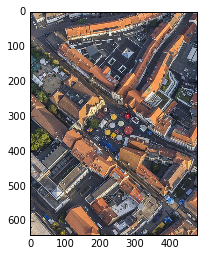

In [20]:
test_img = '/home/download/city.jpg'
display_image(test_img)

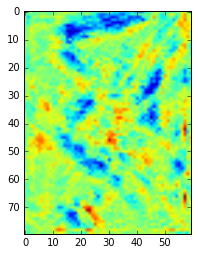

In [21]:
ans=pred_single_image_depth_using_fine(test_img)
plt.imshow(ans[0])